Sorted image files:
['IMG_1.jpg', 'IMG_2.jpg', 'IMG_3.jpg', 'IMG_4.jpg', 'IMG_5.jpg', 'IMG_6.jpg', 'IMG_7.jpg', 'IMG_8.jpg', 'IMG_9.jpg', 'IMG_10.jpg']


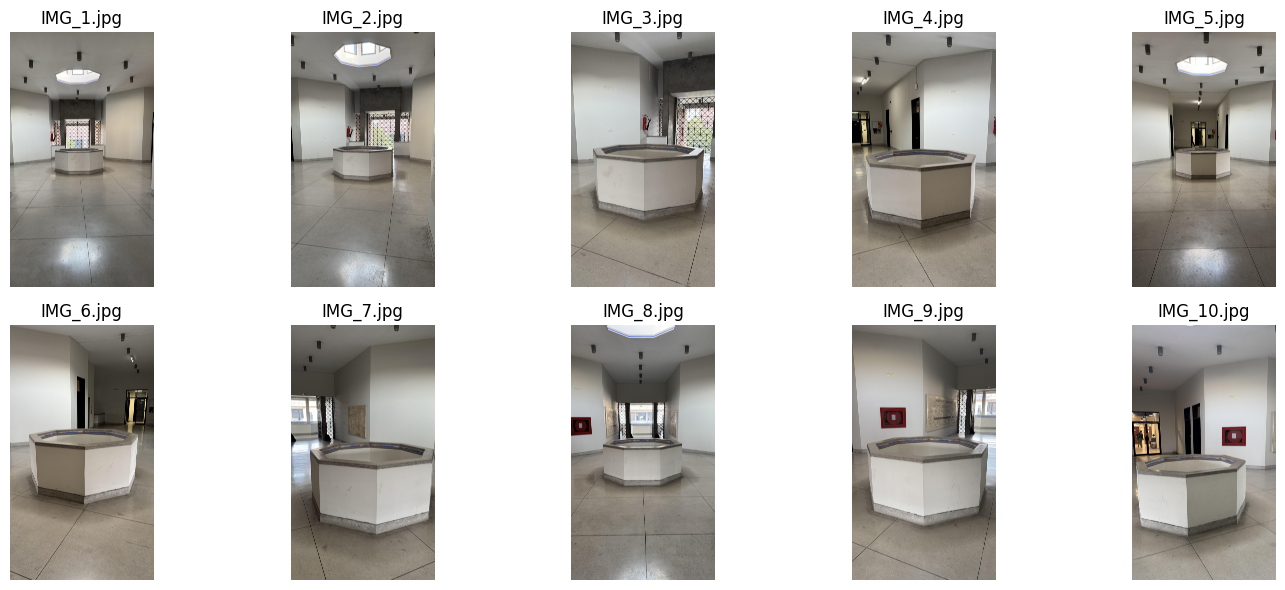

In [19]:
import matplotlib.pyplot as plt
import glob, os
import random
import numpy as np
from itertools import combinations
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import cv2
import re

def natural_sort_key(s):
    return [int(t) if t.isdigit() else t.lower()
            for t in re.split(r'(\d+)', s)]
image_folder = "/Users/ibrahimanwar/Downloads/prep/converted_jpg"

image_paths = sorted(
    [os.path.join(image_folder, f) 
     for f in os.listdir(image_folder) 
     if f.lower().endswith((".jpg", ".jpeg", ".png", ".heic"))],
    key=natural_sort_key
)

print("Sorted image files:")
print([os.path.basename(p) for p in image_paths[:10]])
images = []
for path in image_paths:
    img = cv2.imread(path)
    if img is not None:
        images.append(img)
num_show = min(10, len(images))
first_images = images[:num_show]

plt.figure(figsize=(15, 6))
for i, img in enumerate(first_images):
    plt.subplot(2, 5, i + 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(os.path.basename(image_paths[i]))

plt.tight_layout()
plt.show()


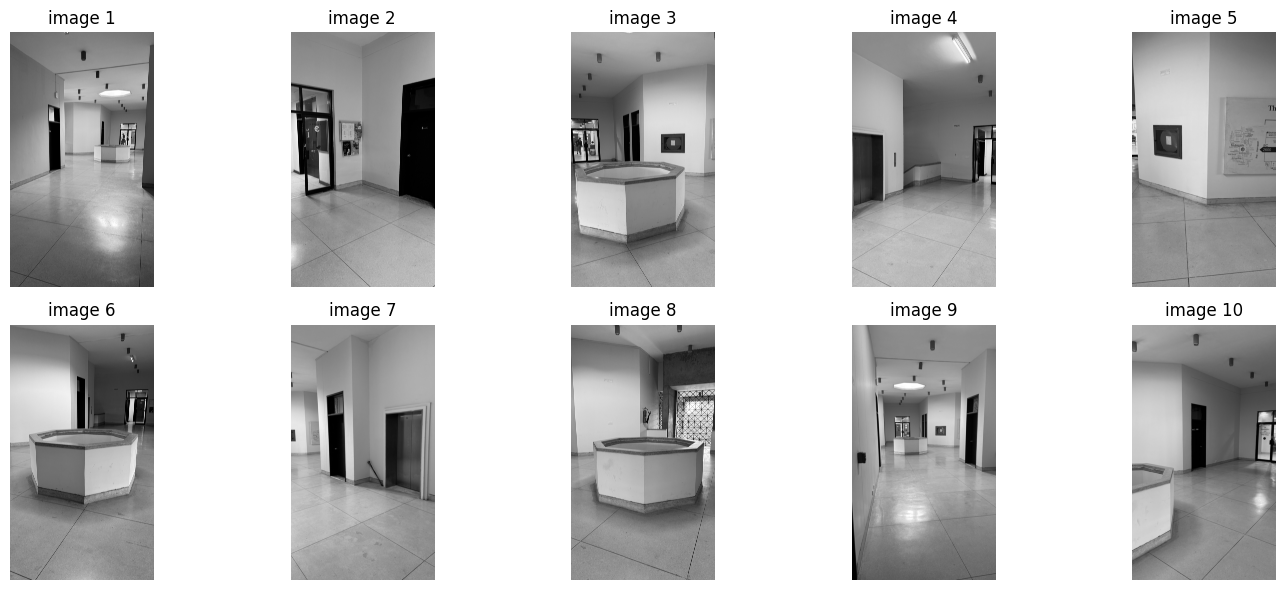

In [20]:
preprocessed_images = []
for img in images:
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5,5), 0)
    preprocessed_images.append(blur)

plt.figure(figsize=(15,6))
for i, img in enumerate(random.sample(preprocessed_images, min(10, len(preprocessed_images)))):
    plt.subplot(2,5,i+1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(f'image {i+1}')
plt.tight_layout()
plt.show()


Image 10 ↔ Image 11: Total matches = 12436, Lowe's matches = 5542


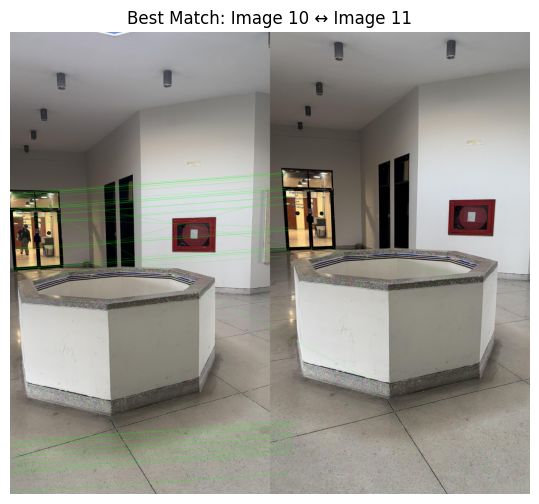

Image 23 ↔ Image 24: Total matches = 6620, Lowe's matches = 2105


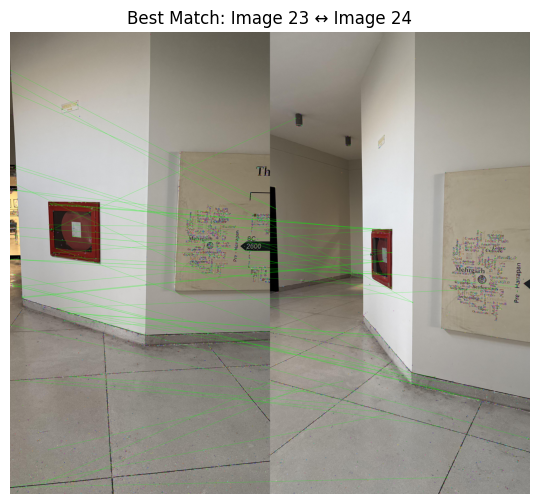

Image 1 ↔ Image 26: Total matches = 13824, Lowe's matches = 1715


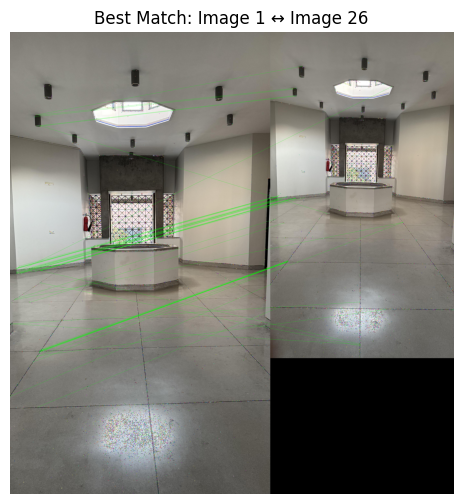

Image 3 ↔ Image 21: Total matches = 19678, Lowe's matches = 1705


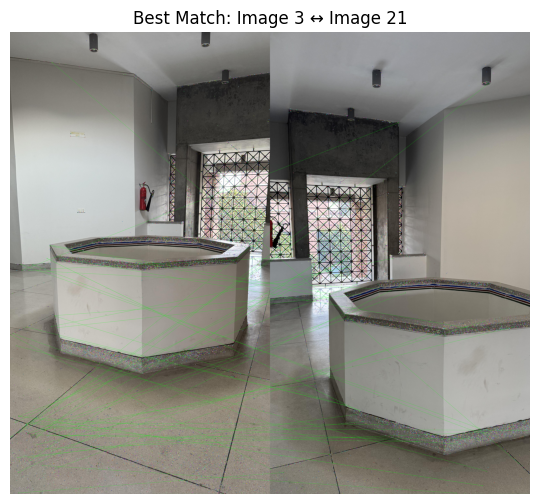

Image 7 ↔ Image 9: Total matches = 15496, Lowe's matches = 1620


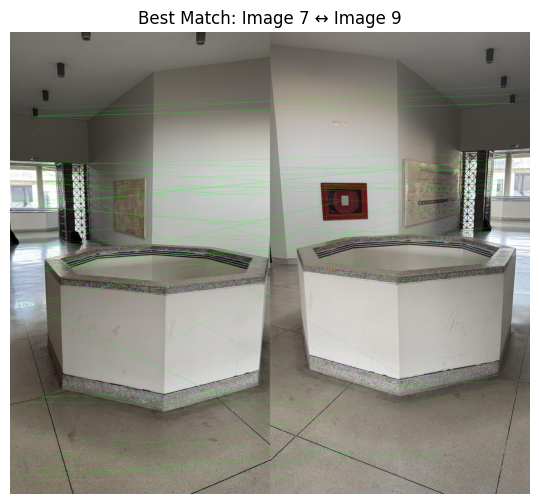

In [21]:
import numpy as np
sift = cv2.SIFT_create()
keys = []
descriptors = []
for img in preprocessed_images:
    kp, des = sift.detectAndCompute(img, None)
    keys.append(kp)
    descriptors.append(des)

bf = cv2.BFMatcher()
ratio_threshold = 0.85
pair_scores = []
for i, j in combinations(range(len(preprocessed_images)), 2):
    matches = bf.knnMatch(descriptors[i], descriptors[j], k=2)
    good_matches = []
    for m, n in matches:
        ratio = m.distance / n.distance
        if ratio < ratio_threshold:
            good_matches.append(m)
    pair_scores.append((i, j, len(matches), len(good_matches)))

pair_scores.sort(key=lambda x: x[3], reverse=True)
best_pairs = pair_scores[:5]
for i, j, total_matches, lowe_matches in best_pairs:
    matches = bf.knnMatch(descriptors[i], descriptors[j], k=2)
    good_matches = []
    for m, n in matches:
        ratio = m.distance / n.distance
        if ratio < ratio_threshold:
            good_matches.append(m)
    good_matches = good_matches[:50]
    matched_img = cv2.drawMatches(images[i], keys[i],images[j], keys[j],good_matches, None, matchColor=(0,255,0))
    print(f"Image {i+1} ↔ Image {j+1}: Total matches = {total_matches}, Lowe's matches = {lowe_matches}")
    plt.figure(figsize=(12,6))
    plt.imshow(cv2.cvtColor(matched_img, cv2.COLOR_BGR2RGB))
    plt.title(f'Best Match: Image {i+1} ↔ Image {j+1}')
    plt.axis('off')
    plt.show()



K:
 [[1.5000e+03 0.0000e+00 1.6065e+03]
 [0.0000e+00 1.5000e+03 2.8560e+03]
 [0.0000e+00 0.0000e+00 1.0000e+00]]

Essential Matrix E:
 [[ 0.01438632  0.13409878  0.01780045]
 [ 0.05074362  0.05922641 -0.70277075]
 [ 0.07550652  0.68698215  0.06227814]]

Rotation R:
 [[ 0.95832912 -0.1361471   0.25113596]
 [ 0.11645282  0.98894903  0.09175273]
 [-0.26085253 -0.05868382  0.96359336]]

Translation t:
 [[-0.98131921]
 [-0.00782096]
 [ 0.19222758]]

Baseline length: 1.0

Extrinsic [R|t]:
 [[ 0.95832912 -0.1361471   0.25113596 -0.98131921]
 [ 0.11645282  0.98894903  0.09175273 -0.00782096]
 [-0.26085253 -0.05868382  0.96359336  0.19222758]]

P1:
 [[1.5000e+03 0.0000e+00 1.6065e+03 0.0000e+00]
 [0.0000e+00 1.5000e+03 2.8560e+03 0.0000e+00]
 [0.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00]]

P2:
 [[ 1.01843409e+03 -2.98496214e+02  1.92471667e+03 -1.16316521e+03]
 [-5.70315587e+02  1.31582254e+03  2.88965174e+03  5.37270521e+02]
 [-2.60852529e-01 -5.86838240e-02  9.63593362e-01  1.92227578e-01]]


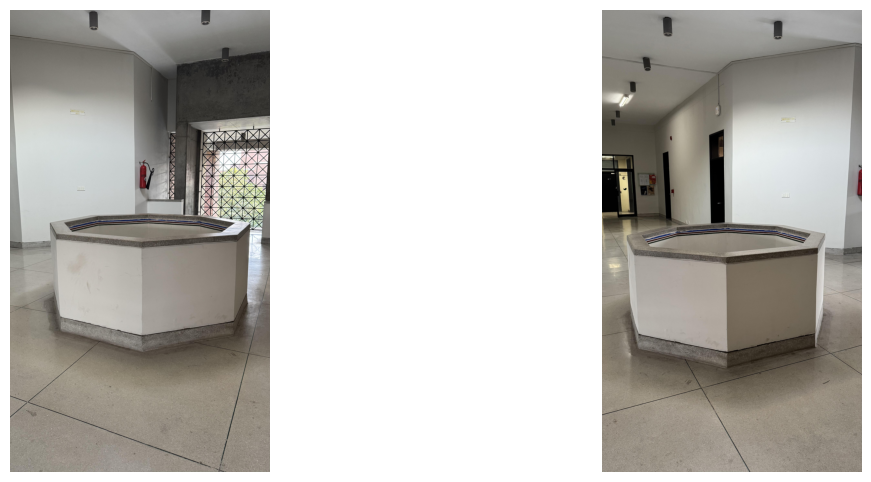

In [22]:
def disparity_score(i, j):
    matches = bf.knnMatch(descriptors[i], descriptors[j], k=2)
    good = [m for m,n in matches if m.distance < ratio_threshold * n.distance]
    if len(good) < 30:
        return 0
    pts1 = np.float32([keys[i][m.queryIdx].pt for m in good])
    pts2 = np.float32([keys[j][m.trainIdx].pt for m in good])
    return np.mean(np.linalg.norm(pts1 - pts2, axis=1))

geo_scores = []
for (i, j, _, _) in pair_scores[:20]:
    geo_scores.append((disparity_score(i, j), i, j))

geo_scores.sort(reverse=True)
_, best_i, best_j = geo_scores[0]


img1 = images[2]
img2 = images[3]
kp1 = keys[2]
kp2 = keys[3]
des1 = descriptors[2]
des2 = descriptors[3]

plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
plt.axis("off")


matches = bf.knnMatch(des1, des2, k=2)
good_matches = [m for m, n in matches if m.distance / n.distance < ratio_threshold]

pts1 = np.float32([kp1[m.queryIdx].pt for m in good_matches])
pts2 = np.float32([kp2[m.trainIdx].pt for m in good_matches])

h, w = img1.shape[:2]
cx, cy = w/2, h/2
fx = fy = 1500.
K = np.array([[fx,0,cx],[0,fy,cy],[0,0,1]], np.float64)
print("\nK:\n", K)

E, mE = cv2.findEssentialMat(pts1, pts2, K, cv2.RANSAC, 0.999, 1.0)
mE = mE.ravel().astype(bool)
print("\nEssential Matrix E:\n", E)
pts1 = pts1[mE]
pts2 = pts2[mE]

_, R, t, mP = cv2.recoverPose(E, pts1, pts2, K)
mP = mP.ravel().astype(bool)
pts1 = pts1[mP]
pts2 = pts2[mP]
print("\nRotation R:\n", R)
print("\nTranslation t:\n", t)
print("\nBaseline length:", np.linalg.norm(t))
print("\nExtrinsic [R|t]:\n", np.hstack((R, t)))

P1 = K @ np.hstack((np.eye(3), np.zeros((3,1))))
P2 = K @ np.hstack((R, t))

pts1_h = np.asarray(pts1, dtype=np.float64).T.reshape(2, -1)
pts2_h = np.asarray(pts2, dtype=np.float64).T.reshape(2, -1)

P1 = np.asarray(P1, dtype=np.float64).reshape(3, 4)
P2 = np.asarray(P2, dtype=np.float64).reshape(3, 4)
print("\nP1:\n", P1)
print("\nP2:\n", P2)

pts4 = cv2.triangulatePoints(P1, P2, pts1_h, pts2_h)
pts3 = (pts4[:3] / pts4[3]).T
pts3 = (pts4[:3] / pts4[3]).T

mask = np.isfinite(pts3).all(axis=1)
pts3 = pts3[mask]
pts1 = pts1[mask]

pts3 -= pts3.mean(axis=0)
s = np.max(np.linalg.norm(pts3, axis=1))
pts3 /= s

img1_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
colors = []
for u, v in pts1:
    ui, vi = int(round(u)), int(round(v))
    if 0 <= vi < img1_rgb.shape[0] and 0 <= ui < img1_rgb.shape[1]:
        colors.append(img1_rgb[vi, ui])
    else:
        colors.append([255,255,255])
colors = np.array(colors, np.uint8)

def save_ply(f, pts, col):
    with open(f, "w") as fp:
        fp.write("ply\nformat ascii 1.0\n")
        fp.write(f"element vertex {pts.shape[0]}\n")
        fp.write("property float x\nproperty float y\nproperty float z\n")
        fp.write("property uchar red\nproperty uchar green\nproperty uchar blue\nend_header\n")
        for (x,y,z),(r,g,b) in zip(pts,col):
            fp.write(f"{x} {y} {z} {r} {g} {b}\n")

save_ply("sfm_best_pair_pointcloud.ply", pts3, colors)
points_3d = pts3



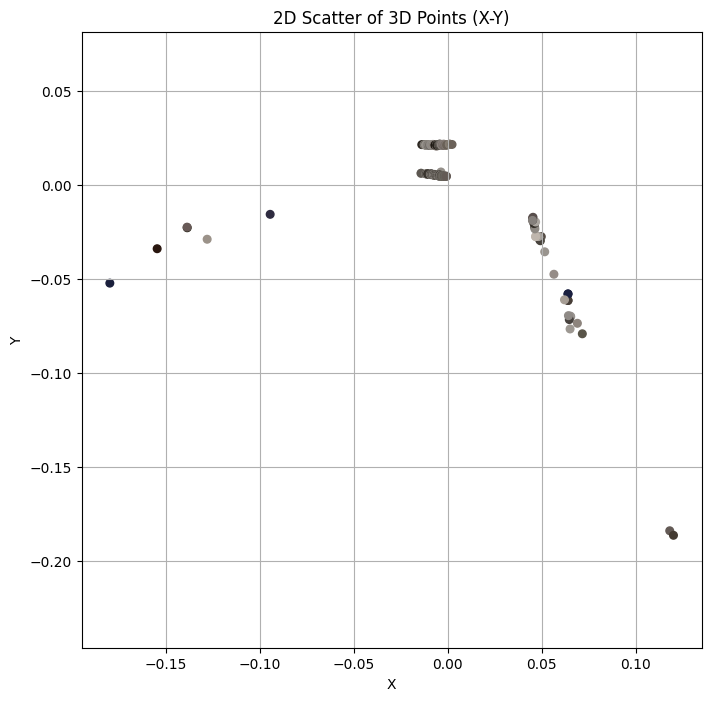

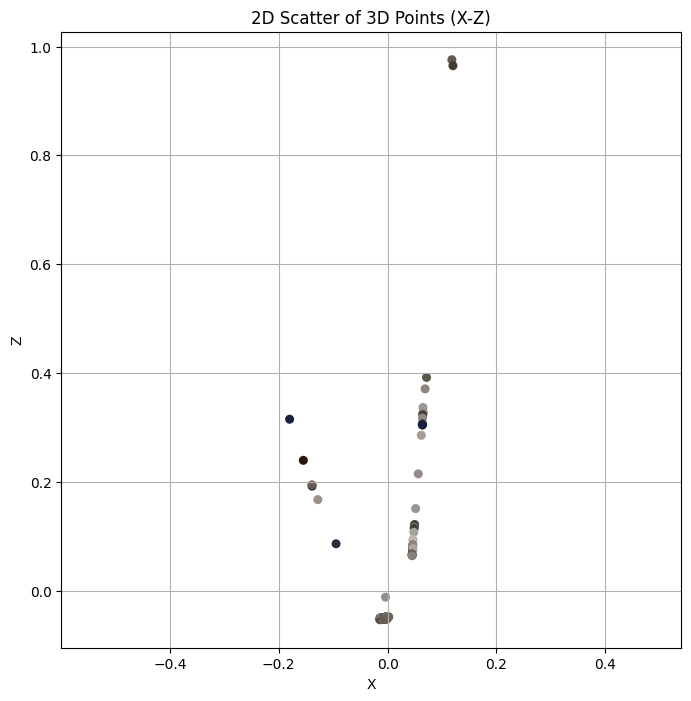

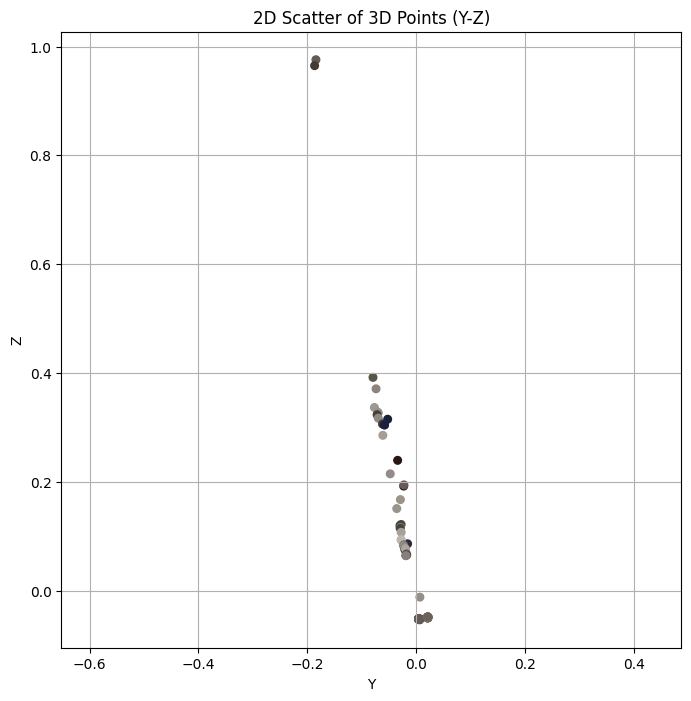

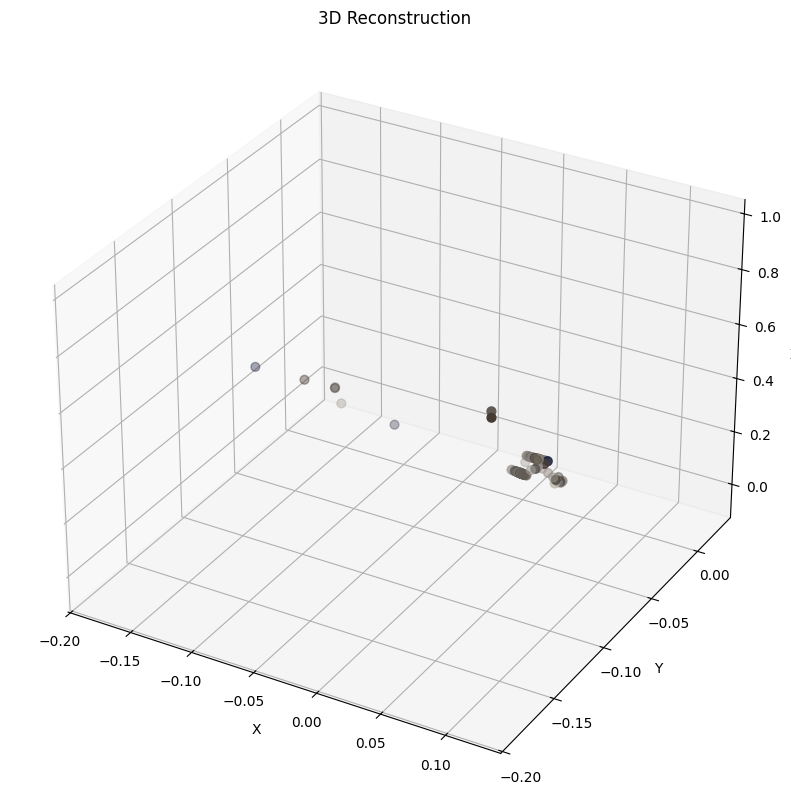

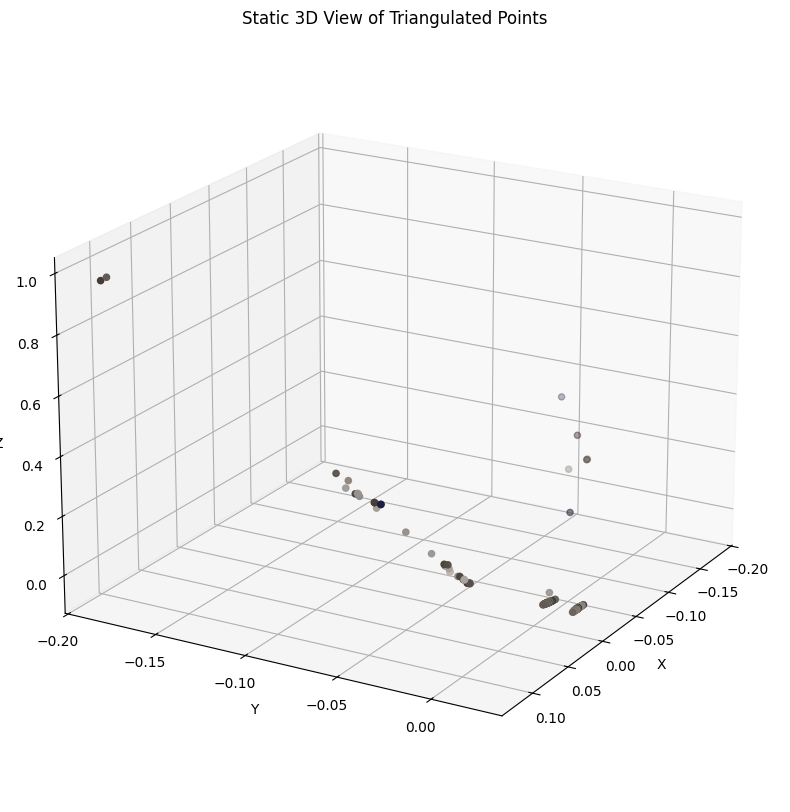

In [23]:

plt.figure(figsize=(8,8))
plt.scatter(points_3d[:,0], points_3d[:,1], c=colors/255.0, s=30)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("2D Scatter of 3D Points (X-Y)")
plt.grid(True)
plt.axis('equal')
plt.show()
plt.figure(figsize=(8,8))
plt.scatter(points_3d[:,0], points_3d[:,2], c=colors/255.0, s=30)
plt.xlabel("X")
plt.ylabel("Z")
plt.title("2D Scatter of 3D Points (X-Z)")
plt.grid(True)
plt.axis('equal')
plt.show()
plt.figure(figsize=(8,8))
plt.scatter(points_3d[:,1], points_3d[:,2], c=colors/255.0, s=30)
plt.xlabel("Y")
plt.ylabel("Z")
plt.title("2D Scatter of 3D Points (Y-Z)")
plt.grid(True)
plt.axis('equal')
plt.show()



fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points_3d[:,0], points_3d[:,1], points_3d[:,2], 
           c=colors/255.0, s=40)
ax.set_title("3D Reconstruction")
ax.set_xlabel("X"); ax.set_ylabel("Y"); ax.set_zlabel("Z")
plt.show()
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

xs = points_3d[:,0]
ys = points_3d[:,1]
zs = points_3d[:,2]

ax.scatter(xs, ys, zs, c=colors/255, s=20)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Static 3D View of Triangulated Points')

ax.view_init(elev=20, azim=30)
plt.show()


In [24]:
import subprocess
from PIL import Image, ExifTags
import numpy as np

def heic_to_jpg_sips(heic_path, out_path):
    subprocess.run(["sips", "-s", "format", "jpeg", heic_path, "--out", out_path])

def extract_focal_mm(val):
    if hasattr(val, "numerator") and hasattr(val, "denominator"):
        return val.numerator / val.denominator
    if isinstance(val, tuple) and len(val) == 2:
        return val[0] / val[1]
    return float(val)

def get_focal_length_px_jpg(img_path, sensor_width_mm=5.76):
    img = Image.open(img_path)
    exif = img._getexif()
    if exif is None:
        return None

    fx_mm = None
    for tag, val in exif.items():
        name = ExifTags.TAGS.get(tag)
        if name == "FocalLength":
            fx_mm = extract_focal_mm(val)
            break

    if fx_mm is None:
        return None

    width = img.size[0]
    fx_px = width * (fx_mm / sensor_width_mm)
    return fx_px

def get_intrinsics_from_heic(heic_path):
    jpg_path = heic_path.replace(".HEIC", "_temp_exif.jpg")
    heic_to_jpg_sips(heic_path, jpg_path)

    fx = get_focal_length_px_jpg(jpg_path)
    img = Image.open(jpg_path)
    W, H = img.size

    if fx is None:
        fx = 1900.0

    K = np.array([
        [fx, 0, W/2],
        [0, fx, H/2],
        [0,  0,   1]
    ], dtype=np.float64)

    return K, fx, W, H

heic_path = "/Users/ibrahimanwar/Downloads/prep/IMG_10.HEIC"
K, fx, W, H = get_intrinsics_from_heic(heic_path)

print("Focal length (px):", fx)
print("Image size:", W, H)
print("Intrinsic matrix K:\n", K)


/Users/ibrahimanwar/Downloads/prep/IMG_10.HEIC
  /Users/ibrahimanwar/Downloads/prep/IMG_10_temp_exif.jpg
Focal length (px): 3773.6014875594487
Image size: 3213 5712
Intrinsic matrix K:
 [[3.77360149e+03 0.00000000e+00 1.60650000e+03]
 [0.00000000e+00 3.77360149e+03 2.85600000e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


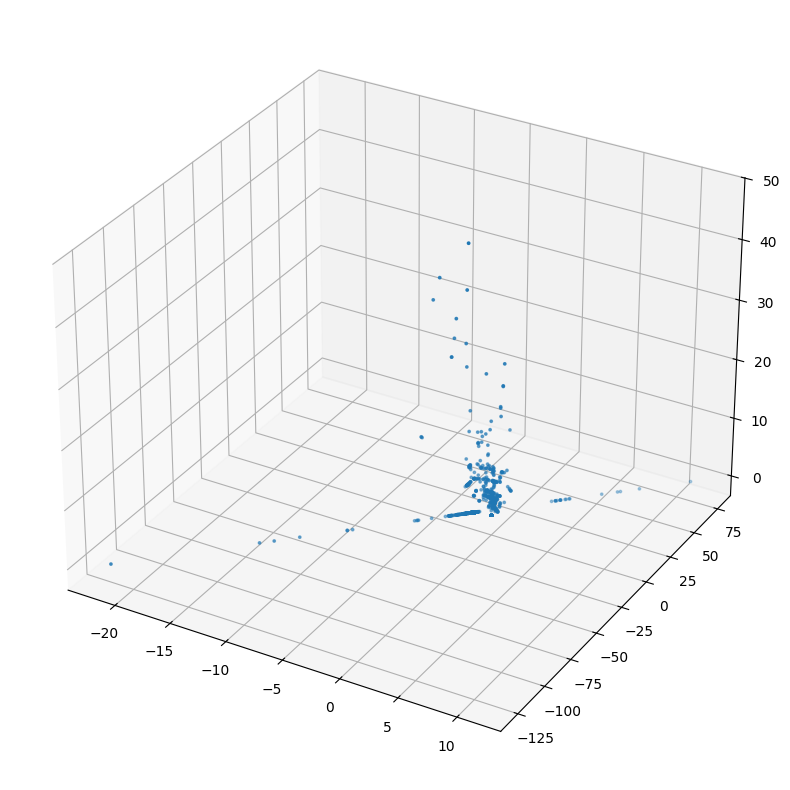

In [25]:
import cv2, numpy as np, math, matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

imgs = [cv2.imread(p) for p in image_paths]
H, W = imgs[0].shape[:2]

def K_from_wh(w,h,fov=64):
    f = w/(2*math.tan(math.radians(fov/2)))
    return np.array([[f,0,w/2],[0,f,h/2],[0,0,1]])

K = K_from_wh(W,H)
sift = cv2.SIFT_create()
bf = cv2.BFMatcher()

kp, des = [], []
for im in imgs:
    k, d = sift.detectAndCompute(im, None)
    kp.append(k); des.append(d)

m12 = bf.knnMatch(des[0],des[1],k=2)
m12 = [m for m,n in m12 if m.distance <0.75*n.distance]
p1 = np.float64([kp[0][m.queryIdx].pt for m in m12])
p2 = np.float64([kp[1][m.trainIdx].pt for m in m12])

E,_ = cv2.findEssentialMat(p1,p2,K,cv2.RANSAC,0.999,1.0)
_,R2,t2,mask = cv2.recoverPose(E,p1,p2,K)

P1 = K @ np.hstack((np.eye(3),np.zeros((3,1))))
P1 = P1.astype(np.float64)
P2 = K @ np.hstack((R2,t2))
P2 = P2.astype(np.float64)

m = mask.ravel().astype(bool)
p1t = p1[m].T
p2t = p2[m].T

pts4 = cv2.triangulatePoints(P1,P2,p1t,p2t)
pts3 = (pts4[:3]/pts4[3]).T

global_points = pts3.copy()
global_obs_2d = {1: p2[m].copy()}
global_idx = np.arange(len(global_points))

camera_poses=[(np.eye(3),np.zeros((3,1))),(R2,t2)]

for i in range(2,len(imgs)):

    matches = bf.knnMatch(des[i-1],des[i],k=2)
    matches = [m for m,n in matches if m.distance<0.75*n.distance]
    q_prev = np.float64([kp[i-1][m.queryIdx].pt for m in matches])
    q_curr = np.float64([kp[i][m.trainIdx].pt for m in matches])

    prev_obs = global_obs_2d[i-1]
    idx_pairs=[]
    for a,(u,v) in enumerate(q_prev):
        d=np.linalg.norm(prev_obs-(u,v),axis=1)
        j=np.argmin(d)
        if d[j]<3: idx_pairs.append((a,j))

    if len(idx_pairs)==0: continue

    idx_prev=[a for a,b in idx_pairs]
    idx_map=[b for a,b in idx_pairs]

    pts_used = global_points[idx_map]
    q_used = q_curr[idx_prev]

    _,rvec,tvec,_ = cv2.solvePnPRansac(pts_used,q_used,K,None)
    R,_ = cv2.Rodrigues(rvec)

    camera_poses.append((R,tvec))
    P_new = K @ np.hstack((R,tvec))

    matches2 = bf.knnMatch(des[i-1],des[i],k=2)
    matches2 = [m for m,n in matches2 if m.distance<0.75*n.distance]

    a_prev = np.float64([kp[i-1][m.queryIdx].pt for m in matches2])
    a_curr = np.float64([kp[i][m.trainIdx].pt for m in matches2])

    pts4_new = cv2.triangulatePoints(camera_poses[i-1][0]@np.hstack((np.eye(3),camera_poses[i-1][1])),
                                     np.hstack((R,tvec)),
                                     a_prev.T,
                                     a_curr.T)

    pts3_new = (pts4_new[:3]/pts4_new[3]).T

    global_idx_new = np.arange(len(pts3_new)) + len(global_points)
    global_points = np.vstack((global_points,pts3_new))
    global_obs_2d[i] = a_curr.copy()

fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(111,projection='3d')
ax.scatter(global_points[:,0],global_points[:,1],global_points[:,2],s=3)
plt.show()
